# Prévalence du Listeria dans le lait cru

In [1]:
!ls

README.md                 listeria.txt              projets2021.pdf
exploratoire_claire.ipynb mcmc.ipynb


In [32]:
import pandas as pd
data = pd.read_csv('listeria.txt', sep=',')
data.columns = ['nb_pos', 'nb_test']
new_row = {'nb_pos':0, 'nb_test':600}
data = data.append(new_row, ignore_index=True)

In [34]:
data.head()

,nb_pos,nb_test
0,0,415
1,0,276
2,0,220
3,0,150
4,0,142


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
data['prob']=data["nb_pos"]/data['nb_test']

On suppose dans un premier temps que la probabilité de présence de listeria dans toutes les études est constante. 

$r_i \sim \mathcal{B}(n_i,p)$
Loi a priori : $p \sim \mathcal{Beta}(\alpha,\beta)$ avec $\alpha, \beta = 1$ ce qui revient à avoir $p \propto \mathcal{U}([0,1])$

On pose $\theta = (\alpha,\beta)$.

Loi a posteriori : $\pi(\theta|r) \propto \prod_i f(r_i|\theta) p_\theta(r) \propto \prod_i f(r_i|\theta) \propto \prod_i \mathbb{1}_{[0,1]}(r_i) $

<AxesSubplot:xlabel='prob', ylabel='Count'>

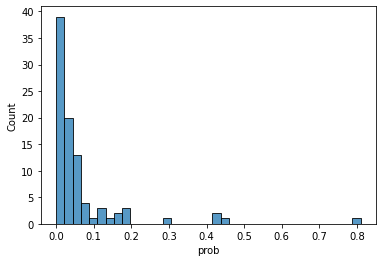

In [42]:
sns.histplot(data, x="prob")

### 

### Loi binomiale

### Loi exponentielle 



In [43]:
def gen_exp(theta):
    u = rd.random()
    return -1/theta*np.log(1-u)

Remarque : sommer les cas/les études pour un gros échantillon
Simuler une loi beta(alpha, beta) à l'aide de simulation de lois gammas. 
